In [1]:
import numpy as np
import json
import os
import helper
import matplotlib.pyplot as plt
import re

In [2]:
pbil_prefix = 'pbil'
self_modelling_learning_prefix = 'self_modelling_learning'
self_modelling_no_learning_prefix = 'self_modelling_no_learning'
cmaes_prefix = 'cmaes_prefix'

def read_file_results(file):
    results_dict = dict()
    with open(file,'r') as f:
        results_dict = json.load(f)
    return results_dict


# List of filepaths of FILES inside a directory
def get_filepaths(directory):
    files = [os.path.join(directory,f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory,f))]
    return files

def is_subset(d1,d2):
    if d1 == d2:
        return True
    for k in d1.keys():
        if k not in d2:
            return False
        if d1[k] != d2[k]:
            return False
    return True

# prefix: Files to collect results
# parameters: The parameters of the collected results
# Return a dictionary mapping filepath to results
def read_directory_results(directory,prefix,parameters):
    results = {}
    files = get_filepaths(directory)
    for file_path in files:
        if not prefix in file_path:
            continue
        file_results = read_file_results(file_path)
        file_parameters = file_results['parameters']
        if is_subset(parameters,file_parameters):
            results[file_path] = file_results
    return results

def learning_rates_from_directory(directory,prefix):
    learning_rates = set()
    files = get_filepaths(directory)
    for file_path in files:
        if not prefix in file_path:
            continue
        file_results = read_file_results(file_path)
        file_parameters = file_results['parameters']
        learning_rate = file_parameters['learning_rate']
        learning_rates.add(learning_rate)
    learning_rates = list(learning_rates)
    learning_rates.sort()
    return learning_rates

def plot_self_modelling_performance(results,ax):
    final_relaxation_energies = [ r['relaxation_energies'][-1] for r in results.values()]
    average_run = np.mean(final_relaxation_energies,axis=0)

    x = range(1,average_run.size+1)
    for e in final_relaxation_energies:
        ax.plot(x,e)
    ax.plot(x,average_run,'--k',label='Average Run')
    ax.set_xlabel('State Update')
    ax.set_ylabel('Energy')
    ax.legend()

def plot_pbil_performance(results,ax):
    mean_sample_energies = [np.mean(r['iteration_energies'],axis=1) for r in results.values()]
    average_run = np.mean(mean_sample_energies,axis=0)
    parameters = [r['parameters'] for r in results.values()][0]
    learning_rate = parameters['learning_rate']

    x = range(1,average_run.size+1)
    for e in mean_sample_energies:
        ax.plot(x,e)
    ax.plot(x,average_run,'--k',label='Average Run')
    ax.set_title(f'Learning Rate: {learning_rate}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Energy')
    ax.legend()

    final_average_run_energy = average_run[-1]
    mean_sample_energies = np.array(mean_sample_energies)
    final_energies = mean_sample_energies[:,-1]
    best_final_energy, worst_final_energy = np.min(final_energies), np.max(final_energies)
    print('Learning Rate',learning_rate)
    print('Final average energy:',final_average_run_energy)
    print('Final energy range:',worst_final_energy,best_final_energy)

def plot_cmaes_performance(results,ax):
    mean_sample_energies = [np.mean(r['iteration_energies'],axis=1) for r in results.values()]
    average_run = np.mean(mean_sample_energies,axis=0)
    parameters = [r['parameters'] for r in results.values()][0]
    sigma = parameters['sigma']

    x = range(1,average_run.size+1)
    for e in mean_sample_energies:
        ax.plot(x,e)
    ax.plot(x,average_run,'--k',label='Average Run')
    ax.set_title(f'Sigma: {sigma}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Energy')
    ax.legend()

    final_average_run_energy = average_run[-1]
    mean_sample_energies = np.array(mean_sample_energies)
    final_energies = mean_sample_energies[:,-1]
    best_final_energy, worst_final_energy = np.min(final_energies), np.max(final_energies)
    print('Sigma',sigma)
    print('Final average energy:',final_average_run_energy)
    print('Final energy range:',worst_final_energy,best_final_energy)


In [3]:
N = 100
seed_weights = 0
seed_states = 1
hyperparameters_dir = '../experiments/weighted_max_2_sat/hyperparameters/'
performance_dir = '../experiments/weighted_max_2_sat/performance/'

cmaes_results = read_directory_results(hyperparameters_dir,'cmaes',{'iterations': 1000, 'population_size': 200, 'sigma': 0.997})
pbil_results = read_directory_results(hyperparameters_dir,'pbil',{'iterations': 1000, 'population_size': 200, 'learning_rate':0.014})
#self_modelling_no_learning_results = read_directory_results(hyperparameters_dir,'self_modelling_no_learning',{'relaxations': 1,'hebbian_learning_relaxation': -1})
hopfield_no_learning_results = read_directory_results(hyperparameters_dir,'self_modelling_no_learning',{'relaxations': 1, 'state_updates': 200_000})

len(cmaes_results), len(pbil_results), len(hopfield_no_learning_results)

(30, 15, 15)

In [4]:
self_modelling_no_learning_file = 'self_modelling_no_learning_energies_4_relaxations.npy'
self_modelling_no_learning_energies = np.load(self_modelling_no_learning_file)
self_modelling_no_learning_energies.shape

(50, 200000)

In [5]:
learning_rate = 10 ** - 12
self_modelling_learning_rate_energies_file = 'self_modelling_learning_energies_4_relaxations.json'
with open(self_modelling_learning_rate_energies_file,'r') as file:
    self_modelling_learning_rate_energies = json.load(file)
    self_modelling_learning_rate_energies = {float(k):v for k,v in self_modelling_learning_rate_energies.items()}
self_modelling_learning_energies = self_modelling_learning_rate_energies[learning_rate]
self_modelling_learning_energies = np.array(self_modelling_learning_energies)
self_modelling_learning_energies.shape

(10, 200000)

# Function Calls

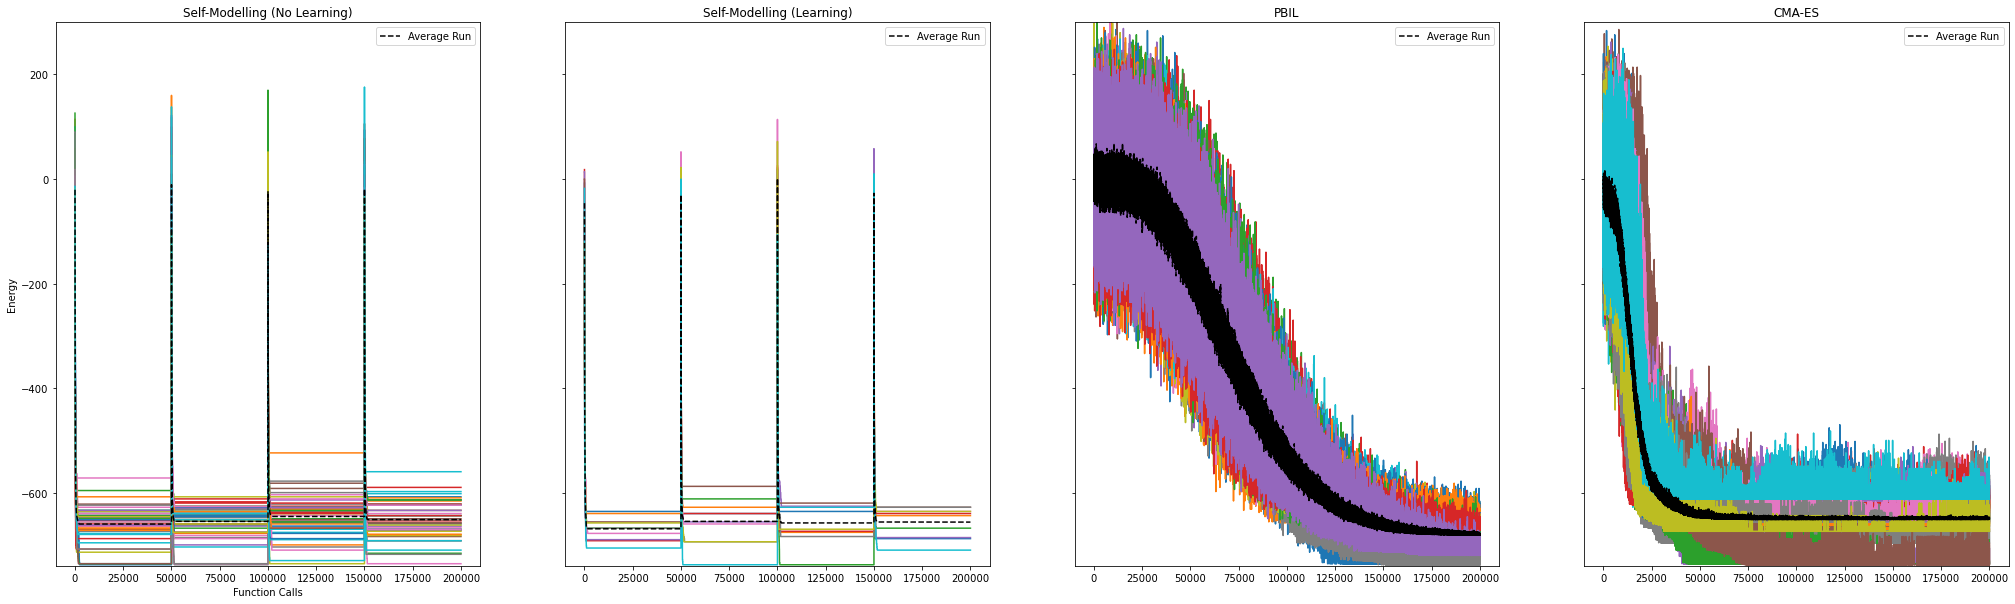

In [6]:
def get_pbil_cmaes_function_call_energies(results):
    energies = [r['iteration_energies'] for r in results.values()]
    energies = np.array(energies)
    number_runs = energies.shape[0]
    energies =  energies.reshape((number_runs,-1))
    return energies

def get_self_modelling_function_call_energies(results):
    energies = [r['relaxation_energies'] for r in results.values()]
    energies = np.array(energies)
    number_runs = energies.shape[0]
    energies = energies.reshape((number_runs,-1))
    return energies

def get_average_run(energies):
    return np.mean(energies,axis=0)

pbil_fcall_energies = get_pbil_cmaes_function_call_energies(pbil_results)
cmaes_fcall_energies = get_pbil_cmaes_function_call_energies(cmaes_results)
#hopfield_no_learning_fcall_energies = get_self_modelling_function_call_energies(hopfield_no_learning_results)
self_modelling_learning_fcall_energies = self_modelling_learning_energies
self_modelling_no_learning_fcall_energies = self_modelling_no_learning_energies

fig,axs = plt.subplots(nrows=1,ncols=4,sharex=True,sharey=True,figsize=(35,10))

axs[0].plot(self_modelling_no_learning_fcall_energies.T)
axs[1].plot(self_modelling_learning_fcall_energies.T)
axs[2].plot(pbil_fcall_energies.T)
axs[3].plot(cmaes_fcall_energies.T)

axs[0].plot(get_average_run(self_modelling_no_learning_fcall_energies),'--k',label='Average Run')
axs[1].plot(get_average_run(self_modelling_learning_fcall_energies),'--k',label='Average Run')
axs[2].plot(get_average_run(pbil_fcall_energies),'--k',label='Average Run')
axs[3].plot(get_average_run(cmaes_fcall_energies),'--k',label='Average Run')

axs[0].set_title('Self-Modelling (No Learning)')
axs[1].set_title('Self-Modelling (Learning)')
axs[2].set_title('PBIL')
axs[3].set_title('CMA-ES')

axs[0].set_xlabel('Function Calls')
axs[0].set_ylabel('Energy')

axs[0].set_ylim(-740,300)

[ax.legend() for ax in axs]
plt.show()

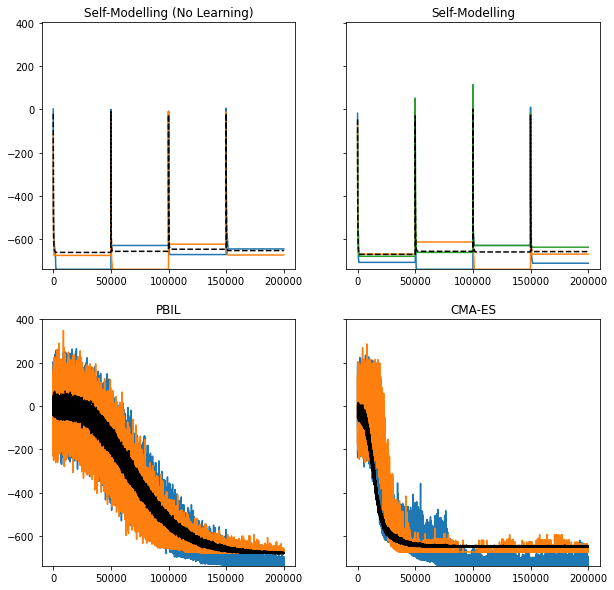

In [7]:
def get_best_worst_runs(energies):
    best_runs = []
    worst_runs = []
    max_energy = np.max(energies)
    min_energy = np.min(energies)
    for i,run_e in enumerate(energies):
        if np.max(run_e) == max_energy:
            worst_runs.append(i)
        if np.min(run_e) == min_energy:
            best_runs.append(i)
    return best_runs, worst_runs

fig,axs = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=True,figsize=(10,10))
ax0, ax1 = axs

ax0[0].plot(self_modelling_no_learning_fcall_energies[10])
ax0[0].plot(self_modelling_no_learning_fcall_energies[17])
ax0[0].plot(get_average_run(self_modelling_no_learning_fcall_energies),'--k',label='Average')

ax0[1].plot(self_modelling_learning_fcall_energies[9])
ax0[1].plot(self_modelling_learning_fcall_energies[2])
ax0[1].plot(self_modelling_learning_fcall_energies[6])
ax0[1].plot(get_average_run(self_modelling_learning_fcall_energies),'--k',label='Average')

ax1[0].plot(pbil_fcall_energies[7])
ax1[0].plot(pbil_fcall_energies[1])
ax1[0].plot(get_average_run(pbil_fcall_energies),'--k',label='Average')

ax1[1].plot(cmaes_fcall_energies[25])
ax1[1].plot(cmaes_fcall_energies[5])
ax1[1].plot(get_average_run(cmaes_fcall_energies),'--k',label='Average')

ax0[0].set_ylim(-738,None)
ax1[0].set_ylim(-738,None)

ax0[0].set_title('Self-Modelling (No Learning)')
ax0[1].set_title('Self-Modelling')

ax1[0].set_title('PBIL')
ax1[1].set_title('CMA-ES')

plt.show()

# Time

In [8]:
self_modelling_no_learning_results = read_directory_results(performance_dir,'self_modelling_no_learning',{'relaxations':4,'hebbian_learning_relaxation': -1, 'learning_rate': 0})
learning_rate = 10 ** -12
self_modelling_learning_results = read_directory_results(performance_dir,'self_modelling_learning',{'relaxations':4,'hebbian_learning_relaxation': 1, 'learning_rate': learning_rate})
len(self_modelling_no_learning_results), len(self_modelling_learning_results)

(30, 30)

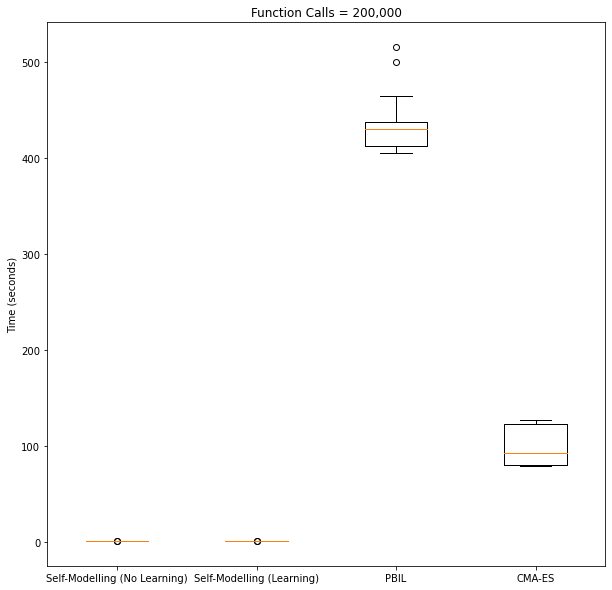

In [9]:
def pbil_cmaes_times(results):
    execution_times = [r['iteration_times'] for r in results.values()]
    # Each row stores the times per iteration
    return np.array(execution_times)

def self_modelling_times(results):
    execution_times = [np.array(r['relaxation_times']).reshape(-1) for r in results.values()]
    return np.array(execution_times)

pbil_execution_times = pbil_cmaes_times(pbil_results)
cmaes_execution_times = pbil_cmaes_times(cmaes_results)
hopfield_execution_times = self_modelling_times(hopfield_no_learning_results)
self_modelling_no_learning_times = self_modelling_times(self_modelling_no_learning_results)
self_modelling_learning_times = self_modelling_times(self_modelling_no_learning_results)

pbil_final_execution_times = np.sum(pbil_execution_times,axis=1) 
cmaes_final_execution_times = np.sum(cmaes_execution_times,axis=1)
hopfield_final_execution_times = np.sum(hopfield_execution_times,axis=1)
self_modelling_no_learning_final_execution_times = np.sum(self_modelling_no_learning_times,axis=1)
self_modelling_learning_final_execution_times = np.sum(self_modelling_learning_times,axis=1)

x = [self_modelling_no_learning_final_execution_times,self_modelling_learning_final_execution_times,pbil_final_execution_times,cmaes_final_execution_times]
labels=['Self-Modelling (No Learning)','Self-Modelling (Learning)','PBIL','CMA-ES']

fig,ax = plt.subplots(figsize=(10,10))
ax.boxplot(x,notch=False,vert=True,labels=labels)
ax.set_title('Function Calls = 200,000')
ax.set_ylabel('Time (seconds)')
plt.show()